In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Simulate A/B test data
n_users = 10000

# Control group (baseline 8% conversion)
control = pd.DataFrame({
    'user_id': range(1, n_users//2 + 1),
    'variant': 'control',
    'converted': np.random.binomial(1, 0.08, n_users//2)
})

# Treatment group (10% conversion - 25% relative lift)
treatment = pd.DataFrame({
    'user_id': range(n_users//2 + 1, n_users + 1),
    'variant': 'treatment',
    'converted': np.random.binomial(1, 0.10, n_users//2)
})

# Combine
df = pd.concat([control, treatment], ignore_index=True)

# Save
df.to_csv('ab_test_data.csv', index=False)
print(f"Generated {len(df)} records")
print(df.groupby('variant')['converted'].agg(['sum', 'mean']))

Generated 10000 records
           sum    mean
variant               
control    393  0.0786
treatment  482  0.0964


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('ab_test_data.csv')
print(df.head())
print(df.groupby('variant')['converted'].agg(['count', 'sum', 'mean']))

   user_id  variant  converted
0        1  control          0
1        2  control          1
2        3  control          0
3        4  control          0
4        5  control          0
           count  sum    mean
variant                      
control     5000  393  0.0786
treatment   5000  482  0.0964


In [4]:
# Separate control and treatment
control = df[df['variant'] == 'control']['converted']
treatment = df[df['variant'] == 'treatment']['converted']

# Two-proportion z-test (using chi-square approximation)
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(df['variant'], df['converted'])
print(contingency_table)

# Run chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("\nResult is STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print("\nResult is NOT statistically significant")

converted     0    1
variant             
control    4607  393
treatment  4518  482

Chi-square statistic: 9.6989
P-value: 0.0018
Degrees of freedom: 1

Result is STATISTICALLY SIGNIFICANT (p < 0.05)


In [5]:
# Calculate conversion rates
control_rate = control.mean()
treatment_rate = treatment.mean()
lift = (treatment_rate - control_rate) / control_rate

print(f"Control conversion rate: {control_rate:.2%}")
print(f"Treatment conversion rate: {treatment_rate:.2%}")
print(f"Relative lift: {lift:.2%}")

# 95% Confidence Interval for difference
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

counts = np.array([treatment.sum(), control.sum()])
nobs = np.array([len(treatment), len(control)])

z_stat, p_val = proportions_ztest(counts, nobs)
print(f"\nZ-statistic: {z_stat:.4f}")
print(f"P-value (z-test): {p_val:.4f}")

Control conversion rate: 7.86%
Treatment conversion rate: 9.64%
Relative lift: 22.65%

Z-statistic: 3.1497
P-value (z-test): 0.0016


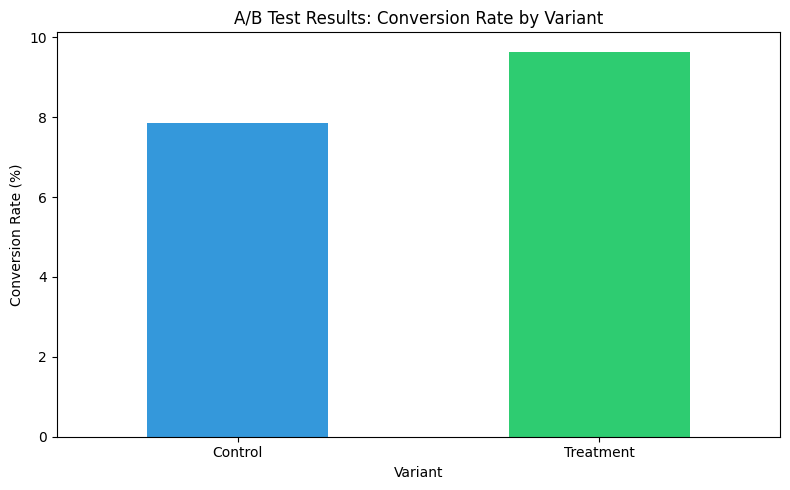

In [7]:
# Bar chart
summary = df.groupby('variant')['converted'].agg(['mean', 'count'])
summary['conversion_rate'] = summary['mean'] * 100

fig, ax = plt.subplots(figsize=(8, 5))
summary['conversion_rate'].plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71'])
ax.set_ylabel('Conversion Rate (%)')
ax.set_xlabel('Variant')
ax.set_title('A/B Test Results: Conversion Rate by Variant')
ax.set_xticklabels(['Control', 'Treatment'], rotation=0)
plt.tight_layout()
plt.savefig('ab_test_results.png')
plt.show()